In [1]:
import pickle

para = 'Rest'

# Load meta dict

with open('../../AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
# Load rest subject ids and splits

with open('../../../BrainAgePredictWrat/' + para + 'Only10FoldSplit.bin', 'rb') as f:
    splits = pickle.load(f)
    subids = splits['cand' + para + 'YesWrat']
    groups = splits['groups']
    
print(len(subids))

804


In [2]:
import numpy as np

paradigm = 'rest'
subidsNp = np.array(subids)

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

all_ts = [loadSeries('../..', paradigm, meta[subid][paradigm]) for subid in subidsNp]

print('Loading complete')

Loading complete


In [3]:
# Normalize timeseries

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print('nan {:}'.format(i))
        if np.sum(np.isinf(subj)) > 0:
            print('inf {:}'.format(i))
            
normalizeSubjects(all_ts)

print('Complete')

Complete


In [5]:
# Create feature vectors (right now just ages, maleness, and femaless)

X_all = []
for subid in subidsNp:
    subj = meta[subid]
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_all.append(feat)
X_all = np.vstack(X_all)

print(X_all[10:20])
print('Complete')

[[223   1   0]
 [190   0   1]
 [197   0   1]
 [145   1   0]
 [148   0   1]
 [142   0   1]
 [123   1   0]
 [176   1   0]
 [129   0   1]
 [173   1   0]]
Complete


In [6]:
# Calculate pearson matrices

all_p = np.stack([np.corrcoef(ts) for ts in all_ts])

print(all_p.shape)

(804, 264, 264)


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nRoi = 264

class Trans(nn.Module):
    def __init__(self):
        super(Trans, self).__init__()
        self.trans = nn.Transformer(d_model=nRoi, nhead=8, 
                                    num_encoder_layers=2, num_decoder_layers=2, 
                                    dim_feedforward=100, dropout=0.1).cuda()
        self.fc1 = nn.Linear(264,50).cuda()
        self.fc2 = nn.Linear(50,1).cuda()
        
    def forward(self, x):
        nB = x.shape[0]
        x = torch.cat([x, torch.ones(nB, nRoi, 1).cuda()], dim=2)
        x = x.permute(2,0,1)
        x = self.trans(x,x)#,src_mask=mask,tgt_mask=mask)
        x = x[nRoi,:,:]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

all_p_t = torch.from_numpy(all_p).float()
agesPredTrans = torch.zeros(all_p_t.shape[0])
# mask = (torch.arange(0,232).float().unsqueeze(1)@torch.ones(1,232)).cuda()

import random

# Loop over splits 
splitIdx = 0
for trainIdcs, testIdcs in groups:
    trans = Trans()
    optim = torch.optim.Adam(trans.parameters(), lr=2e-4)

    train_p = all_p_t[trainIdcs].cuda()
    test_p = all_p_t[testIdcs]

    X_train = X_all[trainIdcs,0]

    running = 0
    nEpoch = 5000
    pPeriod = 100
    nB = 10
    N = train_p.shape[0]

    for epoch in range(nEpoch):
        batch = []
        truth = torch.zeros(nB).float().cuda()
        for i in range(nB):
            idx = random.randint(0,N-1)
            batch.append(train_p[idx])
            truth[i] = X_train[idx]
        batch = torch.stack(batch)
        optim.zero_grad()
        pred = trans(batch).flatten()
        loss = torch.sum((pred-truth)**2)
        loss.backward()
        running += loss.detach().cpu()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpoch-1:
            if epoch != 0:
                if epoch % pPeriod != 0:
                    running /= epoch % pPeriod
                else:
                    running /= pPeriod
            print('epoch {:d} loss={:f}'.format(epoch, ((running/nB)**0.5)/12))
            running = 0

    print('Finished training')
    
    for i in range(int(test_p.shape[0]/10)+1):
        st = i*10
        end = st+10
        if st >= test_p.shape[0]:
            break
        if end > test_p.shape[0]:
            end = test_p.shape[0]
        test_p_b = test_p[st:end].cuda()
        agesPredTrans[testIdcs[st:end]] = trans(test_p_b).flatten().detach().cpu()
    
    print('Completed split {:}'.format(splitIdx))
    splitIdx += 1

print('All complete')

epoch 0 loss=15.605904
epoch 100 loss=14.768792
epoch 200 loss=13.071994
epoch 300 loss=10.113995
epoch 400 loss=6.821187
epoch 500 loss=4.345365
epoch 600 loss=3.411998
epoch 700 loss=3.292540
epoch 800 loss=3.353905
epoch 900 loss=3.255692
epoch 1000 loss=3.357232
epoch 1100 loss=3.310801
epoch 1200 loss=3.321998
epoch 1300 loss=3.297527
epoch 1400 loss=2.958565
epoch 1500 loss=2.852227
epoch 1600 loss=2.794297
epoch 1700 loss=2.674380
epoch 1800 loss=2.316844
epoch 1900 loss=2.215140
epoch 2000 loss=2.107596
epoch 2100 loss=1.952466
epoch 2200 loss=1.846089
epoch 2300 loss=1.837395
epoch 2400 loss=1.732563
epoch 2500 loss=1.579449
epoch 2600 loss=1.444721
epoch 2700 loss=1.348779
epoch 2800 loss=1.212137
epoch 2900 loss=1.213227
epoch 3000 loss=1.073660
epoch 3100 loss=0.916185
epoch 3200 loss=0.929765
epoch 3300 loss=0.867061
epoch 3400 loss=0.760961
epoch 3500 loss=0.737175
epoch 3600 loss=0.689252
epoch 3700 loss=0.647555
epoch 3800 loss=0.563092
epoch 3900 loss=0.533854
epoch 40

epoch 1600 loss=2.490166
epoch 1700 loss=2.302104
epoch 1800 loss=2.084866
epoch 1900 loss=2.138367
epoch 2000 loss=1.838552
epoch 2100 loss=1.761227
epoch 2200 loss=1.561201
epoch 2300 loss=1.559705
epoch 2400 loss=1.251991
epoch 2500 loss=1.274771
epoch 2600 loss=1.241686
epoch 2700 loss=1.119808
epoch 2800 loss=0.938898
epoch 2900 loss=0.897559
epoch 3000 loss=0.716196
epoch 3100 loss=0.704695
epoch 3200 loss=0.632522
epoch 3300 loss=0.605505
epoch 3400 loss=0.604586
epoch 3500 loss=0.532407
epoch 3600 loss=0.580473
epoch 3700 loss=0.548995
epoch 3800 loss=0.523523
epoch 3900 loss=0.476800
epoch 4000 loss=0.474471
epoch 4100 loss=0.429861
epoch 4200 loss=0.385191
epoch 4300 loss=0.439962
epoch 4400 loss=0.431679
epoch 4500 loss=0.385900
epoch 4600 loss=0.401533
epoch 4700 loss=0.373840
epoch 4800 loss=0.379872
epoch 4900 loss=0.360653
epoch 4999 loss=0.377957
Finished training
Completed split 6
epoch 0 loss=16.019857
epoch 100 loss=14.779472
epoch 200 loss=13.038594
epoch 300 loss=9

[[1.        0.5077879]
 [0.5077879 1.       ]]
2.9651592507345526
2.357189943936729


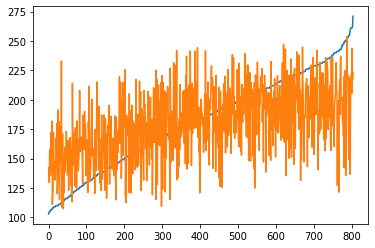

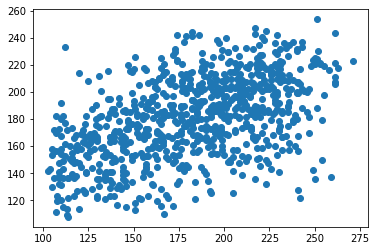

In [15]:
import matplotlib.pyplot as plt

test_labels = X_all[:,0]
predY = agesPredTrans.detach().cpu().numpy()
# test_labels = X_all[testIdcs,0]
# predY = trans(test_ts).flatten().detach().cpu().numpy()

idcs = np.argsort(test_labels[:])
yPred = predY[idcs]
y = test_labels[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

In [9]:
# Save predictions

with open('../../../BrainAgePredictWrat/TransPearson/TransformerPearsonRestPredictions.bin', 
          'wb') as f:
    pickle.dump(agesPredTrans.detach().cpu().numpy(), f)
    
print('Complete')

Complete


In [10]:
# Check predictions

with open('../../../BrainAgePredictWrat/TransPearson/TransformerPearsonRestPredictions.bin', 
          'rb') as f:
    check = pickle.load(f)
    
print(check[0:10])
print(agesPredTrans[0:10])
print(np.count_nonzero(check == agesPredTrans.detach().cpu().numpy()))
print(check.shape[0])

[165.0274  189.83698 117.70208 160.53876 143.49861 181.32304 150.86024
 188.07884 182.77785 163.55516]
tensor([165.0274, 189.8370, 117.7021, 160.5388, 143.4986, 181.3230, 150.8602,
        188.0788, 182.7778, 163.5552])
804
804
